# UFC Fight Prediction

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

### Load and Clean Data

In [3]:
raw = pd.read_csv('ufc-master.csv')
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6528 entries, 0 to 6527
Columns: 118 entries, RedFighter to BKOOdds
dtypes: bool(1), float64(60), int64(43), object(14)
memory usage: 5.8+ MB


In [4]:
not_num = raw.select_dtypes(['object']).columns
not_num

Index(['RedFighter', 'BlueFighter', 'Date', 'Location', 'Country', 'Winner',
       'WeightClass', 'Gender', 'BlueStance', 'RedStance', 'BetterRank',
       'Finish', 'FinishDetails', 'FinishRoundTime'],
      dtype='object')

In [5]:
raw.drop(columns = ['RedFighter', 'BlueFighter', 'Date', 'Location', 'Country', 'Gender', 'BetterRank', 'Finish', 'FinishDetails', 'FinishRoundTime'], inplace = True)

raw.select_dtypes(['object'])

,Winner,WeightClass,BlueStance,RedStance
0,Red,Flyweight,Orthodox,Orthodox
1,Red,Welterweight,Orthodox,Orthodox
2,Red,Heavyweight,Orthodox,Orthodox
3,Red,Featherweight,Southpaw,Southpaw
4,Blue,Featherweight,Orthodox,Orthodox
...,...,...,...,...
6523,Blue,Lightweight,Orthodox,Orthodox
6524,Red,Welterweight,Southpaw,Orthodox
6525,Red,Heavyweight,Orthodox,Orthodox
6526,Red,Welterweight,Orthodox,Orthodox


In [6]:
stance_map = {'Orthodox': 0, 'Southpaw': 1, 'Switch': 2, 'Open Stance': 3}
raw['BlueStance'] = raw['BlueStance'].replace(stance_map)
raw['RedStance'] = raw['RedStance'].replace(stance_map)

win_map = {'Red': 0, 'Blue': 1}
raw['Winner'] = raw['Winner'].replace(win_map)
raw['Winner'].replace(np.nan, 2, inplace = True)

/var/folders/dd/1z0t59cd1yz727ndmzd5xk1h0000gn/T/ipykernel_23454/372759028.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  raw['RedStance'] = raw['RedStance'].replace(stance_map)
/var/folders/dd/1z0t59cd1yz727ndmzd5xk1h0000gn/T/ipykernel_23454/372759028.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  raw['Winner'] = raw['Winner'].replace(win_map)
/var/folders/dd/1z0t59cd1yz727ndmzd5xk1h0000gn/T/ipykernel_23454/372759028.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assi

In [7]:
raw['Winner'].unique()
raw['Winner'].value_counts()

Winner
0    3787
1    2741
Name: count, dtype: int64

In [8]:
x = raw.drop(columns = ['Winner'])
y = raw['Winner']

In [9]:
def fill_nan(x):
    df_filled = x.copy()
    numeric_cols = df_filled.select_dtypes(include=[np.number]).columns
    df_filled[numeric_cols] = df_filled.groupby('WeightClass')[numeric_cols].transform(lambda x: x.fillna(x.mean()))

    remaining_na = df_filled[numeric_cols].isna().sum().sum()
    if remaining_na > 0:
        df_filled[numeric_cols] = df_filled[numeric_cols].fillna(df_filled[numeric_cols].mean())

    return df_filled

x_filled = fill_nan(x)

x_filled.replace(np.nan, 0, inplace = True)

x_filled_num = x_filled.select_dtypes(include=[np.number])


In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_filled_num, y, test_size = 0.2, random_state = 42)

In [11]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5222, 104)
(1306, 104)
(5222,)
(1306,)


In [12]:
seed = 350
np.random.seed(seed)

### Initialize Models

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#### Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter = 1000)
kfold_lr = StratifiedKFold(n_splits = 10, random_state = seed, shuffle = True)
cv_lr = cross_val_score(lr, x_train, y_train, cv = kfold_lr)
lr_score = cv_lr.mean()
lr.fit(x_train, y_train)

print('Logistic Regression kfold score:', lr_score) 
print('Logistic Regression kfold mean score:', lr_score)    

Logistic Regression kfold score: 0.6566463740723646
Logistic Regression kfold mean score: 0.6566463740723646


#### Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = seed)
kfold_rf = StratifiedKFold(n_splits = 10, random_state = seed, shuffle = True)
cv_rf = cross_val_score(rf, x_train, y_train, cv = kfold_rf)
rf_score = cv_rf.mean()

print('Random Forest kfold score:', rf_score)  
print('Random Forest kfold mean score:', rf_score)


Random Forest kfold score: 0.6464912859058043
Random Forest kfold mean score: 0.6464912859058043


#### K-Nearest Neighbors

In [16]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
kfold_knn = StratifiedKFold(n_splits = 10, random_state = seed, shuffle = True)
cv_knn = cross_val_score(knn, x_train, y_train, cv = kfold_knn)
knn_score = cv_knn.mean()

print('KNN kfold score:', knn_score)
print('KNN kfold mean score:', knn_score)

KNN kfold score: 0.5903826289532098
KNN kfold mean score: 0.5903826289532098


#### Decision Tree

In [17]:
from sklearn import tree

dt = tree.DecisionTreeClassifier(random_state = seed)
kfold_dt = StratifiedKFold(n_splits = 10, random_state = seed, shuffle = True)
cv_dt = cross_val_score(dt, x_train, y_train, cv = kfold_dt)
dt_score = cv_dt.mean()

print('Decision Tree kfold score:', dt_score)
print('Decision Tree kfold mean score:', dt_score)

Decision Tree kfold score: 0.5704676820289664
Decision Tree kfold mean score: 0.5704676820289664


### Neural Network

In [18]:
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [19]:
x_train_tensor = torch.tensor(x_train, dtype = torch.float32)
x_test_tensor = torch.tensor(x_test, dtype = torch.float32)

y_train_tensor = torch.tensor(y_train, dtype = torch.long)
y_test_tensor = torch.tensor(y_test, dtype = torch.long)

In [20]:
class NN(nn.Module):
    def __init__(self, input_dim):
        super(NN, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 2)

        self.dropout = nn.Dropout(0.3)

        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(32)
        
    def forward(self, x):
        
        x = self.layer1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.layer2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.layer3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.layer4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.output(x)
        
        return F.log_softmax(x, dim = 1)

In [21]:
model = NN(x_train_tensor.shape[1])

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [23]:
def train_nn(nn, x_train, y_train, epochs, batch_size):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    nn = nn.to(device)
    
    train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.LongTensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    
    train_losses = []
    nn.train()

    for epoch in range(epochs):
        epoch_loss = 0.0
        batch_count = 0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()

            output = nn(batch_x)
            loss = criterion(output, batch_y)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            batch_count += 1

        avg_epoch_loss = epoch_loss / batch_count
        train_losses.append(avg_epoch_loss)

        if epoch % 50 == 0:
            print(f'Epoch: {epoch}, Loss: {avg_epoch_loss:.4f}')

    return train_losses

In [24]:
def eval_nn(nn, x_test, y_test, batch_size, criterion):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    nn = nn.to(device)
    
    test_dataset = TensorDataset(torch.FloatTensor(x_test), torch.LongTensor(y_test))
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
    
    nn.eval()
    test_loss = 0.0
    batch_count = 0
    predictions = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            output = nn(batch_x)
            loss = criterion(output, batch_y)

            test_loss += loss.item()
            batch_count += 1
            
            _, predicted = torch.max(output, 1)
            predictions.extend(predicted.cpu().numpy())
        
        avg_test_loss = test_loss / batch_count

        print(f'Average Test Loss: {avg_test_loss:.4f}')

    return avg_test_loss, predictions



In [25]:
def get_score(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(x_test)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == y_test).sum().item()/len(y_test)
        return accuracy

In [26]:
def predict(nn, x_test):
    nn.eval()
    with torch.no_grad():
        output = nn(x_test)
        _, predicted = torch.max(output, 1)
        return predicted

In [ ]:
model_trained = train_nn(model, x_train_tensor, y_train_tensor, 500, 32)

Epoch: 0, Loss: 0.6605
Epoch: 50, Loss: 0.4025
Epoch: 100, Loss: 0.3009
Epoch: 150, Loss: 0.2616
Epoch: 200, Loss: 0.2131
Epoch: 250, Loss: 0.2207
Epoch: 300, Loss: 0.2107
Epoch: 350, Loss: 0.1863
Epoch: 400, Loss: 0.1954
Epoch: 450, Loss: 0.1706


In [28]:
val_model = eval_nn(model, x_test_tensor, y_test_tensor, 32, criterion)

Average Test Loss: 1.2079


In [29]:
score = get_score(model, x_test_tensor, y_test_tensor)
print('NN Accuracy:', score)

NN Accuracy: 0.608728943338438


In [32]:
scores = [['Logistic Regression', lr_score], ['Random Forest', rf_score], ['KNN', knn_score], ['Decision Tree', dt_score], ['Neural Network', score]]

df_scores = pd.DataFrame(scores, columns = ['Model', 'Score'])
df_scores

,Model,Score
0,Logistic Regression,0.656646
1,Random Forest,0.646491
2,KNN,0.590383
3,Decision Tree,0.570468
4,Neural Network,0.608729


### Confusion Matrix Plots 

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

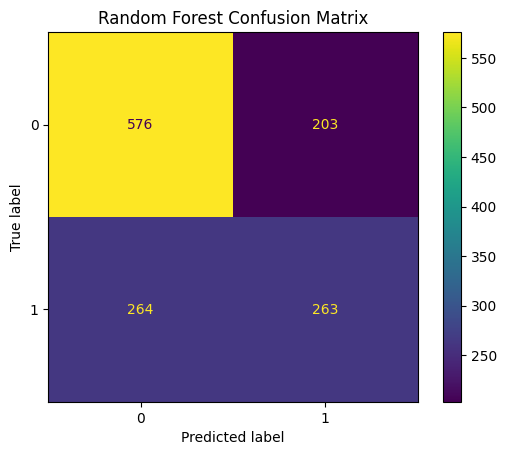

In [34]:
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)
rf_cm = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(rf_cm, display_labels = encoder.classes_)
disp_rf.plot()
disp_rf.ax_.set_title('Random Forest Confusion Matrix')
plt.show()

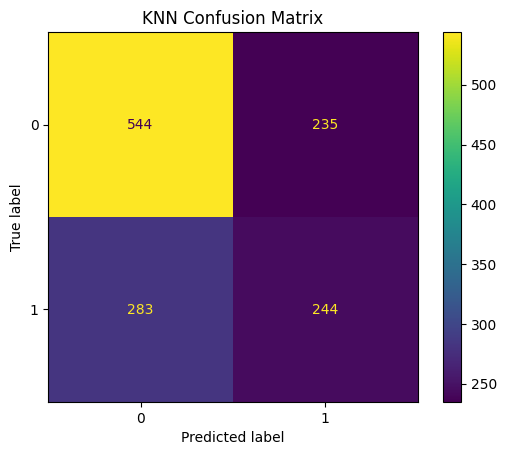

In [35]:
knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_test)
knn_cm = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(knn_cm, display_labels = encoder.classes_)
disp_knn.plot()
disp_knn.ax_.set_title('KNN Confusion Matrix')
plt.show()

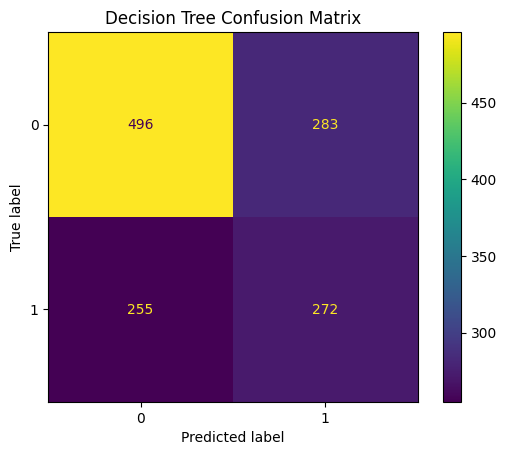

In [36]:
dt.fit(x_train, y_train)
y_pred_dt = dt.predict(x_test)
dt_cm = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(dt_cm, display_labels = encoder.classes_)
disp_dt.plot()
disp_dt.ax_.set_title('Decision Tree Confusion Matrix')
plt.show()

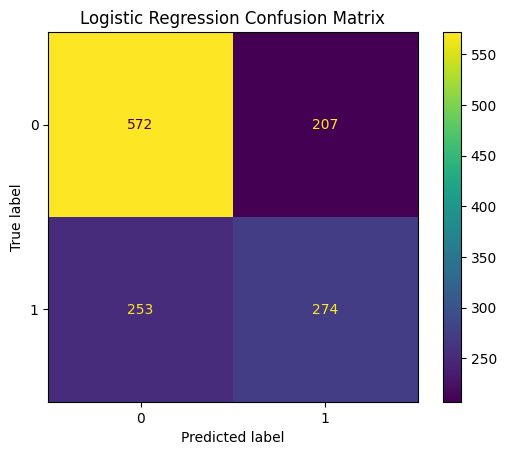

In [37]:
y_pred_lr = lr.predict(x_test)
lr_cm = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(lr_cm, display_labels = encoder.classes_)
disp_lr.plot()
disp_lr.ax_.set_title('Logistic Regression Confusion Matrix')
plt.show()